<a href="https://colab.research.google.com/github/cnovak232/DL_Speech_Enhancement/blob/autoencoders/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Data by cloning the repo - easiest way to access shared data

In [6]:
!git clone https://github.com/cnovak232/DL_Speech_Enhancement.git

Cloning into 'DL_Speech_Enhancement'...
remote: Enumerating objects: 13094, done.
remote: Counting objects: 100% (2414/2414), done.
remote: Compressing objects: 100% (2411/2411), done.
remote: Total 13094 (delta 9), reused 2399 (delta 2), pack-reused 10680
Receiving objects: 100% (13094/13094), 2.71 GiB | 24.08 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Updating files: 100% (13035/13035), done.


Define some helper function for plotting and playing audio

In [3]:
import torch
import torchaudio as ta
import librosa as lib
from IPython.display import Audio, display
import matplotlib
import matplotlib.pyplot as plt

# helper functions for audio and what not
# mostly taken for torchaudio tutorials 

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)

    figure.suptitle(title)
    plt.show(block=False)

def get_spectrogram(
    waveform = None,
    n_fft = 512,
    win_len = None,
    hop_len = None,
    power = 1.0 ):
    spectrogram = ta.transforms.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power )
    
    return spectrogram(waveform)

def plot_spectrogram(spec, type = "amplitude", title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    toDb = ta.transforms.AmplitudeToDB(type)
    im = axs.imshow(spec, origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def norm_spec( spec ):
    normed = spec / spec.max()
    return normed, spec.max()

Define a Custom Dataset class for the Data and read it in

torch.Size([1, 257, 313])
torch.Size([1, 257, 313])
31441


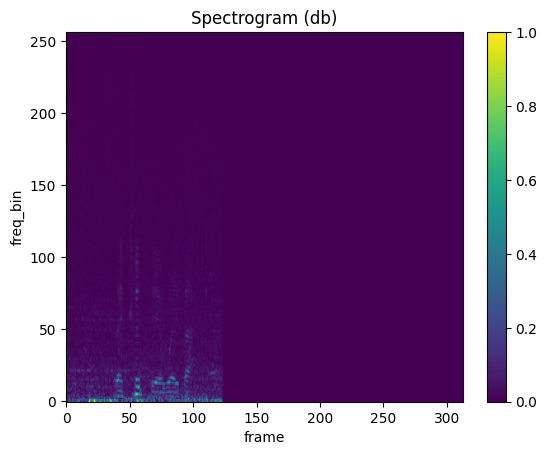

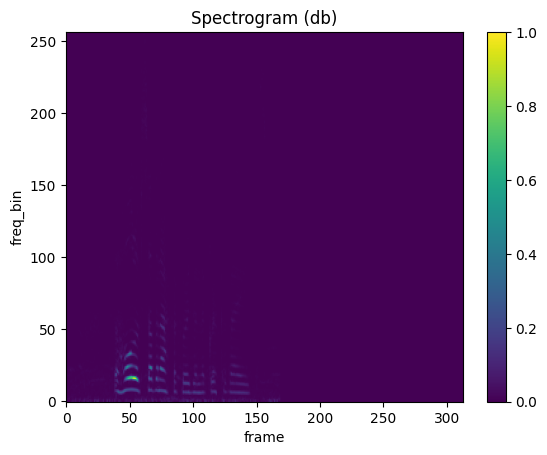

In [7]:
# read dataset in and downsample / transform / pad if needed
from torch.utils.data import Dataset
import torch
import os

class VoiceBankDemand(Dataset):
    def __init__(self, clean_dir, noisy_dir, list_dir, 
                 data = "train", len_samples = None, downsample = None, 
                 transform = None ):
        self.clean_dir = clean_dir
        self.noisy_dir = noisy_dir
        self.list_dir = list_dir
        self.num_samples = len_samples
        self.downsample = downsample
        self.transform = transform
        self.data = data
    
    def __len__(self):
        return len(self.list_dir)

    def __getitem__( self, idx ):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        clean_name = os.path.join( self.clean_dir, self.list_dir[idx] )
        noisy_name = os.path.join( self.noisy_dir, self.list_dir[idx] )
        #remember ta is torchaudio, it returns the waveform and sample rate
        clean_audio, fs = ta.load(clean_name)
        noisy_audio, fs= ta.load(noisy_name)

        #downsamples the data, right now to 16kHz
        if self.downsample:
            downsampler = ta.transforms.Resample(fs,self.downsample)
            clean_audio = downsampler( clean_audio )
            noisy_audio = downsampler( noisy_audio )

        if self.num_samples:
            orig_len = clean_audio.shape[1]
            if clean_audio.shape[1] > num_samples:
                clean_audio = clean_audio[:,:num_samples]
                noisy_audio = noisy_audio[:,:num_samples]
            elif clean_audio.shape[1] < num_samples:
                pad_len = int( num_samples - clean_audio.shape[1] )
                pad = torch.zeros(1,pad_len)
                clean_audio = torch.cat((clean_audio,pad), dim=1)
                noisy_audio = torch.cat((noisy_audio,pad),dim=1)
        
        if self.data == "test":
            if self.transform:
                noisy_trnsfrm = self.transform( noisy_audio )
                clean_trnsfrm = self.transform( clean_audio )
            clean_mag,_ = norm_spec( torch.abs(clean_trnsfrm) )
            clean_audio = (clean_audio, clean_mag)
            noisy_mag, norm_val = norm_spec( torch.abs(noisy_trnsfrm) )
            noisy_phase = torch.angle(noisy_trnsfrm)
            noisy_audio = (noisy_mag, noisy_phase, noisy_audio, norm_val)
        else:
            if self.transform:
                clean_audio,_ = norm_spec( self.transform( clean_audio ) )
                noisy_audio,_ = norm_spec( self.transform( noisy_audio ) )

        sample = (clean_audio, noisy_audio, orig_len)

        return sample

train_clean_path = './DL_Speech_Enhancement/clean_trainset_28spk_wav'
train_noisy_path = './DL_Speech_Enhancement/noisy_trainset_28spk_wav'
test_clean_path  = './DL_Speech_Enhancement/clean_testset_wav'
test_noisy_path  = './DL_Speech_Enhancement/noisy_testset_wav'

list_dir_train = os.listdir(train_clean_path)
list_dir_test = os.listdir(test_clean_path)

target_fs = 16000 # downsample to 16 KHz

#torchaudio.transforms module contains common audio processings and feature extractions. 
#Transforms are implemented using torch.nn.Module.
#Create a spectrogram from a audio signal.
spectrogram = ta.transforms.Spectrogram(
    n_fft=512,
    power=1.0,
    normalized = False )
complex_spec = ta.transforms.Spectrogram(
    n_fft=512,
    power=None,
    normalized = False ) # return complex spectrum

num_samples = int( 5.0 * target_fs ) 

train_set = VoiceBankDemand( clean_dir = train_clean_path,
                             noisy_dir = train_noisy_path,
                             list_dir = list_dir_train,
                             len_samples = num_samples, # clip or pad samples to be 5s
                             downsample = target_fs, # downsample to 16Khz
                             transform = spectrogram )

# returns the mag/phase of each audio file 
test_set = VoiceBankDemand( clean_dir = test_clean_path,
                            noisy_dir = test_noisy_path,
                            list_dir = list_dir_test,
                            data = "test",
                            len_samples = num_samples,
                            downsample = target_fs,
                            transform = complex_spec )


clean, noisy, orig_len = train_set[1]
print(clean.size())
print(noisy.size())
print(orig_len)

clean_test, noisy_test, orig_len = test_set[0]

noisy_mag, noisy_phase, noisy_audio, norm_val = noisy_test

plot_spectrogram(noisy.squeeze())
plot_spectrogram(noisy_mag.squeeze())

The next step consists of creating the architecture of an autoencoder. The train set data based on the previous cell has clean and noisy audio as well as the original length of the data. The data has been normalized using the value divided by max. The data was also downsampled by 16kHz.

The following implementation is based on this article: https://medium.com/cubicalchrome/autoencoder-in-spectrogram-1b789f538adb

https://blog.keras.io/building-autoencoders-in-keras.html

Reminder: An autoencoder is a type of artificial neural network used to learn data encodings in an unsupervised manner. The aim of an autoencoder is to learn a lower-dimensional representation (encoding) for a higher-dimensional data, typically for dimensionality reduction, by training the network to capture the most important parts of the input image.

The end goal is the input will be the noisy_data and the labels will be the clean_data. Masking instead of mapping. The model will be trained to map the noisy_data to the clean_data. Then when testing occurs and the model has learned, we will visualize how accurate the model is in mapping the noisy to clean data. 

Masking: LEARN WHERE THE NOISE IS SUBTRACT FROM NOISE TO NOISY.

3 Convolutional Layer (3x3 kernel) and Max Pooling (2x2 kernel).

In [8]:
import keras
from keras import layers

input_img = keras.Input(shape=(1, 257, 313))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

  After creating the architecture. I need to train this autoencoder with the training data. I plan on mixture some of the implementation with work done with the U-Net of this project in the file DL_Final_Project.ipynb

In [10]:
# training (work in progress)
from torch.utils.data import DataLoader

def train_model( model, dataloader, device ):
    #maybe ytisn
    model.train()

    running_loss = 0.0

    # Iterate over data.
    for clean_audio,noisey_audio,orig_len in dataloader:

        # send inputs to gpu
        clean_audio = clean_audio.to(device)
        noisey_audio = noisey_audio.to(device)

        # zero the parameter gradients
        #see how to use the optimizer from autoencoder
        optimizer.zero_grad()
        
        with torch.enable_grad():
            # Send the noisey speech sample through network


            #Potentially use the model fit and delete everything that follows
            output = model(noisey_audio)

            # compute loss between network output and clean audio
            #use the autocoder loss
            loss = criterion(output, clean_audio)

            # backward + optimize 
            #use both the autoencoder loss and optimizer
            loss.backward()
            optimizer.step()

        # statistics
        #use autoencoder loss
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader.dataset)

    return model, epoch_loss

train_loader = DataLoader( train_set, batch_size=64 )
test_loader = DataLoader( test_set, batch_size=64 )
learning_rate = 0.01
num_epochs = 10


device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

#model = model.to(device)

inv_spec = ta.transforms.InverseSpectrogram(n_fft=512, normalized = False )

#for epoch in range(num_epochs):
    #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    #print('-' * 10)

    #model, epoch_loss = train_model( autoencoder, train_loader, device )
    #print('Train Epoch Loss = ', epoch_loss )


for clean_audio,noisey_audio,orig_len in train_loader:
  for clean_audio, noisy_audio, orig_len in test_loader:
        noisy_mag, noisy_phase, noisy_wav, norm_val = noisy_audio
        autoencoder.fit(clean_audio, noisey_audio,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(test_loader, test_loader))


ValueError: ignored